# EECE 7398: Verifiable Machine Learning -- Fall 2025
# Exercise #1: Adversarial Examples & Decision Boundaries

**Submission Instructions:** Please upload a .ipynb file (including your code, plots, and written answers) to Gradescope. This file can be updated unlimited times until the submission deadline.

# Problem 1: Train & Attack an MNIST Classifier

## 1a) Train an MNIST Classifier

To start, train a NN classifier that consists of:
- a "Flatten" layer to convert the (28, 28) images to (784,)
- a fully connected layer with 128 neurons and ReLU activation
- a fully connected (output) layer with 10 neurons (10 neurons for 10 digit categories)
- (optionally) a softmax layer to convert logits to probabilities

You can use the Adam optimizer with cross entropy loss (make sure to use the correct loss depending on whether you included a softmax layer) and it should work pretty well.

**Deliverables**:
- Plot your train and validation loss curves as a function of epoch
- From a test set, provide some examples where your classifier predicted correctly & incorrectly (if applicable)

Using device: cpu


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 512kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.70MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.52MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 01/8 | Train Loss: 0.3170 | Val Loss: 0.1828
Epoch 02/8 | Train Loss: 0.1378 | Val Loss: 0.1348
Epoch 03/8 | Train Loss: 0.0965 | Val Loss: 0.1187
Epoch 04/8 | Train Loss: 0.0733 | Val Loss: 0.1012
Epoch 05/8 | Train Loss: 0.0575 | Val Loss: 0.0952
Epoch 06/8 | Train Loss: 0.0482 | Val Loss: 0.0950
Epoch 07/8 | Train Loss: 0.0375 | Val Loss: 0.0899
Epoch 08/8 | Train Loss: 0.0307 | Val Loss: 0.0980


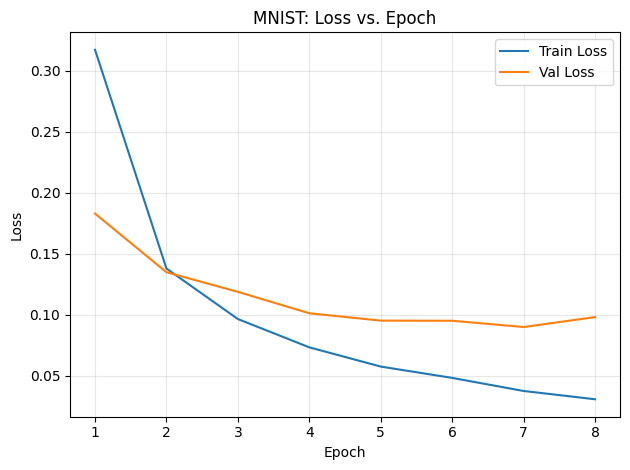

Test Accuracy: 97.32%


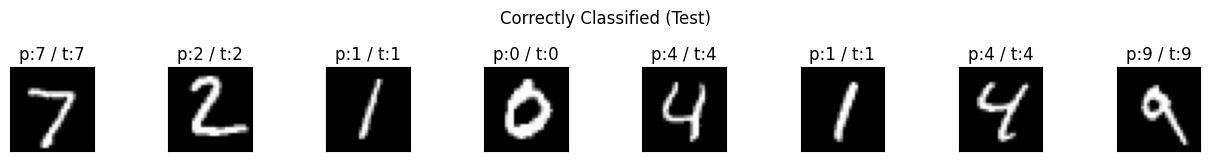

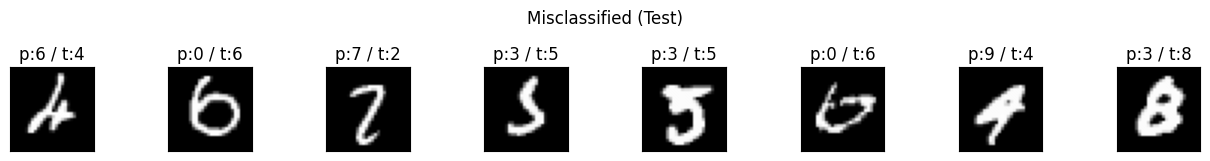

In [1]:
# mnist_classifier.py
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# -----------------------------
# 1) Config
# -----------------------------
batch_size = 128
epochs = 8
lr = 1e-3
val_split = 0.1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# -----------------------------
# 2) Data: transforms and loaders
#    - transforms.ToTensor(): converts [0,255] uint8 to float32 in [0,1]
#    - transforms.Normalize(): standardize inputs (empirical MNIST mean/std)
# -----------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Downloads the dataset on first run (cached afterwards)
train_full = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set   = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Train/validation split
n_train = int((1 - val_split) * len(train_full))
n_val   = len(train_full) - n_train
train_set, val_set = random_split(train_full, [n_train, n_val], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# -----------------------------
# 3) Model
#    - Flatten: (B, 1, 28, 28) -> (B, 784)
#    - Linear(784 -> 128) + ReLU
#    - Linear(128 -> 10)  -> logits (no softmax)
# -----------------------------
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),            # (28,28) -> 784
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 10)       # 10 classes (digits 0..9)
        )
    def forward(self, x):
        return self.net(x)           # returns logits

model = MLP().to(device)

# -----------------------------
# 4) Loss & Optimizer
#    - CrossEntropyLoss expects raw logits; it applies log-softmax internally.
#    - If you ever add a Softmax layer to the model, switch to NLLLoss + LogSoftmax.
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# -----------------------------
# 5) Training & Validation loops
# -----------------------------
def run_epoch(dataloader, train: bool):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    total_samples = 0

    with torch.set_grad_enabled(train):
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)                 # logits
            loss = criterion(outputs, labels)

            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            total_loss += loss.item() * images.size(0)
            total_samples += images.size(0)

    return total_loss / total_samples

train_losses, val_losses = [], []

for epoch in range(1, epochs + 1):
    tr_loss = run_epoch(train_loader, train=True)
    va_loss = run_epoch(val_loader, train=False)
    train_losses.append(tr_loss)
    val_losses.append(va_loss)
    print(f"Epoch {epoch:02d}/{epochs} | Train Loss: {tr_loss:.4f} | Val Loss: {va_loss:.4f}")

# -----------------------------
# 6) Plot: Train vs. Validation loss
# -----------------------------
plt.figure()
plt.plot(range(1, epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, epochs + 1), val_losses, label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("MNIST: Loss vs. Epoch")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# -----------------------------
# 7) Test set evaluation + collect examples
# -----------------------------
model.eval()
correct = 0
total = 0

correct_imgs, correct_preds, correct_labels = [], [], []
wrong_imgs, wrong_preds, wrong_labels = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        preds = logits.argmax(dim=1)

        correct += (preds == labels).sum().item()
        total   += labels.size(0)

        # Save some examples
        for i in range(images.size(0)):
            if preds[i] == labels[i] and len(correct_imgs) < 8:
                correct_imgs.append(images[i].cpu())
                correct_preds.append(int(preds[i].cpu()))
                correct_labels.append(int(labels[i].cpu()))
            elif preds[i] != labels[i] and len(wrong_imgs) < 8:
                wrong_imgs.append(images[i].cpu())
                wrong_preds.append(int(preds[i].cpu()))
                wrong_labels.append(int(labels[i].cpu()))

test_acc = correct / total
print(f"Test Accuracy: {100*test_acc:.2f}%")

# -----------------------------
# 8) Visualization: Correct & Incorrect Predictions
# -----------------------------
def show_examples(imgs, preds, labels, title):
    import numpy as np
    n = len(imgs)
    if n == 0:
        print(f"No {title.lower()} to display.")
        return
    cols = 8
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(1.6*cols, 1.6*rows))
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        # images are normalized; unnormalize roughly for display
        img = imgs[i].squeeze(0).numpy() * 0.3081 + 0.1307
        img = np.clip(img, 0, 1)
        plt.imshow(img, cmap='gray')
        plt.xticks([]); plt.yticks([])
        plt.title(f"p:{preds[i]} / t:{labels[i]}")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_examples(correct_imgs, correct_preds, correct_labels, "Correctly Classified (Test)")
show_examples(wrong_imgs, wrong_preds, wrong_labels, "Misclassified (Test)")


## 1b) Attack your MNIST classifier with constant offsets

Add a constant perturbation to your test set images (e.g., c*torch.ones(28, 28)) and evaluate the performance as the magnitude increases. Also, be sure to clip your perturbed images so each pixel remains in [0, 1] (or [0, 255]).

**Deliverables**:
- Plot your test accuracy as a function of the perturbation magnitude
- Provide some examples where the un-perturbed image was labeled correctly and the perturbed image was labeled incorrectly, despite the perturbed image looking reasonable to a human.

## 1c) Attack your MNIST classifier with noise

Add some noise perturbations to your test set images and evaluate the performance as the noise magnitude increases. Also, be sure to clip your perturbed images so each pixel remains in [0, 1] (or [0, 255]).

**Deliverables**:
- Plot your test accuracy as a function of the perturbation magnitude
- A couple sentences about any differences observed with constant perturbations vs. noise perturbations

## 1d) Attack your MNIST classifier with FGSM

Implement the Fast Gradient Sign Method (FGSM) attack algorithm and experiment with different values of $\epsilon$. You should write FGSM "from scratch" (e.g., using pytorch/numpy to evaluate the gradient, not using a library/method that already implements FGSM).

**Deliverables**:
- Plot your test accuracy as a function of the perturbation magnitude
- A couple sentences about how this curve compares to the constant perturbations and noise perturbations (hopefully, FGSM should be able to achieve lower test accuracy for the same attack magnitude as those model-agnostic attacks)

## 1e) Attack your MNIST classifier with Targeted FGSM

Implement the Targeted Fast Gradient Sign Method (TFGSM) attack algorithm and experiment with different values of $\epsilon$. You should write TFGSM "from scratch" (e.g., using pytorch/numpy to evaluate the gradient, not using a library/method that already implements TFGSM).

**Deliverables**:
- Plot your test accuracy as a function of the perturbation magnitude for each target class
- A few example images where you were able to successfully cause the classifier to predict the targeted (incorrect) class
- A few sentences about your model's susceptibility to targeted attacks (e.g., are some target classes "easier" to get your model to classify? if you try to perturb images labeled 0 to a target class of 8, does the image get perturbed in an intuitive way?)

# Problem 2: Investigating Decision Boundaries

In this problem, you will train a binary classifier for a 2D input vector (is the (x, y) coordinate inside a circle of radius r centered at the origin?).

Since you will know the true decision boundary that the model is trained to approximate, you can generate training data.

Then, you will investigate the model's decision boundary to see how well it matches the true decision boundary.

## 2a) Generate training data

For $x\in R^2$, using the decision rule $f(x) = \begin{cases} 1, &\lvert\lvert x \rvert\rvert_2 \leq 3 \\ 0, & \text{o.w.} \end{cases}$, generate a training, validation, and test set of $[x, f(x)]$ pairs.

**Deliverables:**
- Plot your training set and the true decision boundary

## 2b) Train NN classifier

Train a NN classifier on the data you just generated.

**Deliverables**:
- Plot your train & validation loss curves as a function of epoch

## 2c) Compare decision boundaries

It is unlikely that your model has learned the true decision boundary perfectly. Here, you will investigate the differences.

**Deliverables**:
- Plot the true and learned decision boundaries
- A few sentences (with relevant figures to illustrate observations) about any differences and how changes to the model architecture or training procedure can impact decision boundaries (e.g., adding regularization, changing the training data generation method, changing the activation functions).

# Problem 3: Attack Competition on a Pre-Trained CIFAR-10 Classifier [Extra Credit]

## 3.1 White-Box $l_\infty$-norm Attack

Here, you will have access to the full model (i.e., you know all of its parameters and architecture, you can compute gradients). You should write a function that takes in:
- the model
- a set of images + corresponding labels
- a perturbation magnitude,

and returns a perturbed version of the provided images that will cause the model to have poor classification accuracy.

We provide a template for your attack function and a function for checking the classification accuracy so that you can prototype locally. Once you upload your .ipynb to Gradescope (make sure it is named `hw1.ipynb`), we will run your attack function against some random test images and maintain a leaderboard of the strongest attack (we provide the actual evaluation script below for your convenience). Every student that gets the accuracy below 40% will get some extra credit, and the student with strongest attack will get more extra credit. In case of a tie, we will look at runtime. You can keep updating your submission until the deadline.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import time

Here's a suggested way of getting the CIFAR-10 dataset:

In [ ]:
device = 'cuda'
batch_size = 256

transform = transforms.Compose([transforms.ToTensor()])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2,
                                         pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Here's the model you'll be attacking (ResNet20):

In [ ]:
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)

While CIFAR-10 images have pixel values $\in [0, 1]$, the model we're attacking was trained on a normalized version of CIFAR-10 (i.e., each image was shifted/scaled by a mean/std). You can attack the model in the original pixel coordinates (that's the space we'll enforce the attack magnitude), but remember that any time you want to query the model, you should first normalize the images according to those settings:

In [ ]:
def normalize(imgs):
  mean = (0.4914, 0.4822, 0.4465)
  std = (0.2023, 0.1994, 0.2010)
  Normalize = transforms.Normalize(mean=mean, std=std)
  return Normalize(imgs)

This function may help you when familiarizing yourself with the dataset and baseline model performance (and shows an example of using the normalize function right before querying the model):

In [ ]:
def quickly_run_model(model, testloader, num_to_show=4):
  dataiter = iter(testloader)

  # `images` coming out of the dataloader are tensors of size (batch, 3, 32, 32)
  # where each pixel is within [0, 1].
  images, labels = next(dataiter)

  model = model.to(device)
  images = images.to(device)
  labels = labels.to(device)

  # The model was trained on a normalized version of the dataset
  # (i.e., each pixel was scaled/shifted by mean and std).
  # ==> we will normalize our images in that same way before querying model
  normalized_images = normalize(images)
  outputs = model(normalized_images)
  _, predicted = torch.max(outputs, 1)
  print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                                for j in range(num_to_show)))
  print('Labels: ', ' '.join(f'{classes[labels[j]]:5s}'
                                for j in range(num_to_show)))

quickly_run_model(model, testloader)

The function you will fill in is `white_box_attack`. The autograder expects this exact function name and signature, so make sure those stay the same:

In [ ]:
def white_box_attack(model, raw_images, labels, attack_magnitude):

  # TODO: Fill in this method with your attack algorithm
  # For example, a non-attack would be:
  perturbed_images = raw_images

  return perturbed_images

To help you debug, here's the function we will use to evaluate your `white_box_attack`. This should give 92.6% accuracy when there is no attack. This function is meant to be able to run standalone (i.e., not in a Jupyter notebook where the model/dataset may already be loaded), so feel free to modify it to be more efficient when debugging. We will run your attack against our own replica of this function on Gradescope's servers, so the runtime numbers will likely differ from what you observe locally or on Colab:

In [ ]:
def evaluate_attacked_accuracy(attack_magnitude, attack_fn=white_box_attack, device='cpu'):

  # We will run your attack against this function to establish the leaderboard

  testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
  testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=2,
                                          pin_memory=True)

  model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)

  attack_runtime = 0.
  correct = 0
  total = 0
  model.to(device)
  model.eval()
  for raw_images, labels in testloader:

    raw_images = raw_images.to(device)
    labels = labels.to(device)

    attack_runtime_start = time.time()
    normalized_raw_images = Normalize(raw_images)
    perturbed_images = attack_fn(model, raw_images, normalized_raw_images, labels, attack_magnitude)
    attack_runtime_end = time.time()
    attack_runtime += attack_runtime_end - attack_runtime_start

    assert torch.all(perturbed_images <= 1.) and torch.all(perturbed_images >= 0.), "Perturbed images contain pixels outside of [0, 1]."
    assert torch.all(torch.linalg.vector_norm(perturbed_images - raw_images, ord=torch.inf, dim=(1,2,3)) <= attack_magnitude + 1e-6), "Perturbation violates attack magnitude limit."

    # calculate outputs by running images through the network
    with torch.no_grad():
      normalized_perturbed_images = normalize(perturbed_images)
      outputs = model(normalized_perturbed_images)

    # the class with the highest energy is what we choose as prediction
    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  accuracy = 100 * correct / total

  return accuracy, attack_runtime

You can run the above evaluation function as follows:

In [ ]:
# We will enforce that the l_inf norm of the perturbation is <= attack_magnitude
attack_magnitude = 1./255
accuracy, attack_runtime = evaluate_attacked_accuracy(attack_magnitude)
print(f"Accuracy: {robust_accuracy} %")
print(f"Attack Runtime: {attack_runtime} [s]")